# Demonstration on a toy problem

In [1]:
import numpy as np
import hypothesis
import torch
import os
import matplotlib.pyplot as plt

from hypothesis.visualization.util import make_square
from toy import allocate_prior
from toy import load_estimator
from toy import Simulator
from toy import RatioEstimator
from toy import JointTrain
from toy import JointTest

## Training

We train the ratio estimator using the ratio estimator trainer provided by the [`hypothesis`](https://github.com/montefiore-ai/hypothesis) package.

In [7]:
!python -u -m hypothesis.bin.ratio_estimation.train -h

usage: Conditional likelihood-to-evidence ratio estimator training
       [-h] [--data-parallel] [--disable-gpu] [--out OUT] [--show]
       [--dont-shuffle] [--denominator DENOMINATOR] [--amsgrad]
       [--batch-size BATCH_SIZE] [--conservativeness CONSERVATIVENESS]
       [--epochs EPOCHS] [--logits] [--lr LR] [--lrsched]
       [--lrsched-every LRSCHED_EVERY] [--lrsched-gamma LRSCHED_GAMMA]
       [--weight-decay WEIGHT_DECAY] [--workers WORKERS]
       [--data-test DATA_TEST] [--data-train DATA_TRAIN]
       [--estimator ESTIMATOR]

optional arguments:
  -h, --help            show this help message and exit
  --data-parallel       Enable data-parallel training if multiple GPU's are
                        available (default: false).
  --disable-gpu         Disable the usage of the GPU, not recommended.
                        (default: false).
  --out OUT             Output directory (default: none).
  --show                Show the progress and the final result (default:
        

### Hyperparameters

In [2]:
batch_size = 4096

In [3]:
epochs = 25

In [4]:
learning_rate = 0.0001

In [5]:
weight_decay = 0.0

In [6]:
num_estimators = 5

### Training procedure

In [8]:
!mkdir -p estimators

for index in range(num_estimators):
    path = "estimators/" + str(index).zfill(5)
    # Check if the model has been trained
    if not os.path.exists(path + "/best-model.th"):
        print("\nTraining started!")
        !python -u -m hypothesis.bin.ratio_estimation.train \
           --data-pmularallel \                       # Automatically train the model on multiple GPU's when the resources are available
           --out $path \                              # Store the trained models and other metadata in the specified folder
           --show \                                   # Show the progress of the training procedure in `stdout`
           --denominator "inputs|outputs" \           # Denominator of the training criterion '|' denotes an independence relation. -> p(inputs)p(outputs) -> so the ratio it will learn is p(inputs,outputs)/(p(inputs)p(outputs)) -> pointwise mutual information
           --batch-size $batch_size \                 # Batch size
           --conservativeness 0.0 \                   # Conservativeness criterion, how much weight should be given to the prior. Convenient way to impose a conservative estimation. Setting this value to 1 will result in a posterior that is indistinghuisable from the prior.
           --epochs $epochs \                         # Number of epochs
           --lr $learning_rate \                      # Learning rate
           --lrsched \                                # Enables learning rate scheduling
           --lrsched-every 5 \                        # Schedule every 5 epochs
           --lrsched-gamma 0.5 \                      # Decay learning rate every 5 epochs by 0.5
           --weight-decay $weight_decay \             # Weight decay, automatically enables the AdamW optimizer.
           --workers 8 \                              # Number of concurrent data loaders
           --data-train "toy.JointTrain" \            # Class of the training dataset
           --data-test "toy.JointTest" \              # Class of the test dataset
           --estimator "toy.RatioEstimator"           # Class of the ratio estimator, should accept the keywords defined in `--denominator`, i.e., forward(inputs=inputs, outputs=outputs).


Training started!
Test loss 0.32742386860925643: 100%|████████████| 25/25 [08:43<00:00, 20.93s/it]
Total epochs:		25
Best training loss:	0.2905746400356293
Final training loss:	0.3103407621383667
Best testing loss:	0.3257021857578246
Best test epoch:	22
Final test loss:	0.32742386860925643

Training started!
Test loss 0.3280713619267354: 100%|█████████████| 25/25 [08:43<00:00, 20.93s/it]
Total epochs:		25
Best training loss:	0.28862854838371277
Final training loss:	0.33666640520095825
Best testing loss:	0.32596660906174146
Best test epoch:	19
Final test loss:	0.3280713619267354

Training started!
Test loss 0.3280684971174256: 100%|█████████████| 25/25 [08:38<00:00, 20.75s/it]
Total epochs:		25
Best training loss:	0.28658536076545715
Final training loss:	0.33027875423431396
Best testing loss:	0.32564984469628727
Best test epoch:	22
Final test loss:	0.3280684971174256

Training started!
Test loss 0.3273421041056758: 100%|█████████████| 25/25 [08:50<00:00, 21.24s/it]
Total epochs:		25
Be

## Inference

In [32]:
# Allocate the prior and the simulator
prior = allocate_prior()
simulator = Simulator()

# Draw a sample from the joint.
truth = prior.sample()
x_o = simulator(truth)

# Load the ratio estimator, and prepare the inputs.
resolution = 100
r = load_estimator("estimators/*/best-model.th")
inputs = torch.linspace(prior.low, prior.high, resolution).view(-1, 1)
outputs = x_o.repeat(resolution).view(-1, 1)

We now have all components to compute

$$
\log\hat{p}(\vartheta\vert x) = \log p(\vartheta) + \log\hat{r}(x\vert\vartheta)
$$

In [33]:
# Compute the posterior
log_posterior = prior.log_prob(inputs) + r.log_ratio(inputs=inputs, outputs=outputs)

As you can tell, we compute the posterior density function by evaluating the input space for the observable $x_o$.

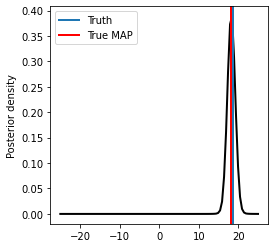

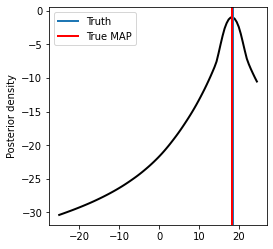

In [34]:
# Plot the posterior
plt.plot(inputs.detach().numpy(), log_posterior.exp().detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()

# Plot the posterior
plt.plot(inputs.detach().numpy(), log_posterior.detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()

Due to the amortization, we can simply evaluate the posterior for a different observable without retraining!

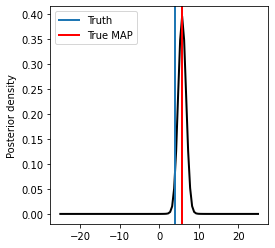

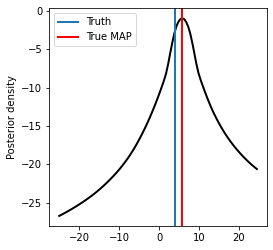

In [39]:
# Draw a sample from the joint.
truth = prior.sample()
x_o = simulator(truth)

# Prepare the inputs for the ratio estimator
inputs = torch.linspace(prior.low, prior.high, resolution).view(-1, 1)
outputs = x_o.repeat(resolution).view(-1, 1)

# Compute the posterior
log_posterior = prior.log_prob(inputs) + r.log_ratio(inputs=inputs, outputs=outputs)

# Plot the posterior
plt.plot(inputs.detach().numpy(), log_posterior.exp().detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()

# Plot the log posterior
plt.plot(inputs.detach().numpy(), log_posterior.detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()